In [1]:
# enviornment imports
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.ticker import AutoMinorLocator
import scipy.signal as sig
import scipy.stats as stat
# local imports
import DataAndPlotting as my
# paths
path_fig  = 'C:\\Users\\polar\\OneDrive - The University of Kansas\\PHSX 616\\GitHub\PHSX616\\Lab3 - Torsional Oscillator\\Figures\\'
path_data = 'C:\\Users\\polar\\OneDrive - The University of Kansas\\PHSX 616\\GitHub\PHSX616\\Lab3 - Torsional Oscillator\\Data\\'

# Data

In [2]:
# store files names for all datasets
filenames: dict[str,str] = {
   'Resonance Vpp=5'    : path_data + 'ResonanceVpp5.csv', 
   'Resonance Vpp=0.25' : path_data + 'ResonanceVpp025.csv', 
   'V1 Ain-Aout t1'     : path_data + 'V1VarVpp.csv', 
   'V1 Ain-Aout t2'     : path_data + 'V1VarVpp_trial2.csv', 
   'V0 Ain-Aout t1'     : path_data + 'V0VarVpp_trial1.csv', 
   'V0 Ain-Aout t2'     : path_data + 'V0VarVpp_trial2.csv', 
   'V0 Ain-Aout t3'     : path_data + 'V0VarVpp_trial3.csv', 
   'V0 Ain-Aout t4'     : path_data + 'V0VarVpp_trial4.csv', 
} # t==trial

tables: dict[str, dict[str, np.array]] = my.UnpackAllTables(filenames)

Resonance Vpp=5 columns:	 ['Freqency [mHz]', 'Max pk-pk [V]', 'Max Amplitude [V]']
Resonance Vpp=0.25 columns:	 ['Freqency [mHz]', 'Max pk-pk [V]', 'Max Amplitude [V]']
V1 Ain-Aout t1 columns:	 ['input Amp. [V]', 'Output Amp. [V]']
V1 Ain-Aout t2 columns:	 ['input Amp. [V]', 'Output Amp. [V]']
V0 Ain-Aout t1 columns:	 ['input Amp. [V]', 'Output Amp. [V]']
V0 Ain-Aout t2 columns:	 ['input Amp. [V]', 'Output Amp. [V]']
V0 Ain-Aout t3 columns:	 ['input Amp. [V]', 'Output Amp. [V]']
V0 Ain-Aout t4 columns:	 ['input Amp. [V]', 'Output Amp. [V]']


# Plots

In [3]:
# https://coolors.co/f75c03-d90368-820263-3c6e71-04a777
# colors = ['#F75C03','#D90368','#820263','#3C6E71','#04A777']

# https://coolors.co/122354-317787-ad9c0b-b85300-782b38
colors = ['#122354','#317787','#AD9C0B','#B85300','#782B38']
colors_dark = [my.darken_color(c, 1.2) for c in colors]

In [258]:
def my_ceil(a, precision=0):
    return np.round(a + 0.5 * 10**(-precision), precision)

def BuildEquationStr(slope, intercept, slopeErr, intErr, roundto=1, yEqn='y') : 
    equn = str(yEqn)+' = ('+str(round(slope,roundto))+'$\pm$'+str(round(slopeErr,roundto))+')x' # y = (m+/-err)x
    if(intercept > 0) : 
        equn += ' $+$ ('+str(my_ceil(intercept,roundto))+'$\pm$'+str(my_ceil(intErr,roundto))+')' # y = (m+/-err)x + (b+/-err)
    elif(intercept < 0) : 
        equn += ' $-$ ('+str(my_ceil(abs(intercept),roundto))+'$\pm$'+str(my_ceil(intErr,roundto))+')' # y = (m+/-err)x - (b+/-err)
    return equn

def ymxb(x,slope,intercept):
    return (slope*x + intercept)

def AxDrawFit(ax,slope,intercept, c=colors[4], xmin=10.0, xmax=40.0, label='') : 
    x = [xmin,xmax]
    y = [ymxb(xmin,slope,intercept), ymxb(xmax,slope,intercept)]
    if(label != '') : 
        ax.plot(x,y, c=c, linestyle='--', label=label)
    else: 
        ax.plot(x,y, c=c, linestyle='--')
    
def LeastSquareFit(ax,x,y,eqnPos='TL',xmin=10.0,xmax=40.0, append='', pltEq=True,c=colors[4], label=False) : 
    # least sequare fit
    result = stat.linregress(x,y)
    equn = BuildEquationStr(result.slope, result.intercept, result.stderr, result.intercept_stderr, yEqn='y$'+str(append)+'$')
    # build array of expected y
    y_exp = []
    for xi in x :
        y_exp.append(ymxb(xi,result.slope,result.intercept))
    # chi squared test
    chi2, pvalue = stat.chisquare(f_obs=y,f_exp=y_exp)
    chi2eqn = '$\chi^2'+str(append)+'$='+str(round(chi2,2))
    # add quation to plot 
    if(pltEq):
        if(eqnPos=='BL') : 
            my.AxTextBL(ax,equn)
            my.AxTextBBL(ax, chi2eqn)
        elif(eqnPos=='TL') : 
            my.AxTextTL(ax,equn)
            my.AxTextTTL(ax, chi2eqn)
    # draw fit line
    lab = ''
    if(label) : lab = str(equn) + ', ' + str(chi2eqn)
    AxDrawFit(ax,result.slope,result.intercept,xmin=xmin, xmax=xmax, c=c, label=lab)
    # print info 
    print(equn, ' , ', chi2eqn)
    return(equn, chi2eqn)

## Resonance

In [5]:
# https://stackoverflow.com/questions/49100778/fwhm-calculation-using-python 
def peak(x, c):
    return np.exp(-np.power(x - c, 2) / 16.0)

def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)]

In [6]:
def plotFWHM(ax,x,y,c) : 
    ypos = max(y)/2.0
    x1,x2 = half_max_x(x,y)
    fwhm = x2-x1
    # add to axis 
    ax.plot([x1,x2], [ypos,ypos], c=c, linestyle='--', alpha=0.5)
    # finish 
    print("FWHM:\t{:.3f}".format(fwhm))
    return fwhm

def plotPeak(ax, x, y, c) : 
    peaky = max(y)
    peakx = x [ np.where(y == peaky) [0][0] ]
    # add to axis 
    ax.axvline(peakx, c=c, linestyle='--', alpha=0.5)
    # finish
    print('Resonance:\t', peakx, peaky)
    return (peakx, peaky)

In [7]:
def PlotXmanyY_peakFWHM(
    x: list[np.array], # x axis data points
    y: list[np.array], # y axis data points
    yleg : list[str], # legend lables 
    c : list, # colors
    xerr: float = 0,    # error on x axis
    yerr: float = 0,    # error on y axis
    xlab: str = '', # label on x axis 
    ylab: str = '', # label on y axis
    linestyle = '-',   # style of xy curve line
    xlim: list = None,  # x axis range 
    ylim: list = None,  # y axis range 
    logScale: bool = False,
    fileName: str = ''  # filename to save the figure as
) : 
    """Plotting function for x and y data arrays."""
    # formatting 
    my.SetStyle()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    if(xlim != None) : plt.xlim(xlim)
    if(ylim != None) : plt.ylim(ylim)
    ax = plt.gca()
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    # ax.grid()
    if(logScale) : ax.set_yscale('log')
    qs = []
    # data
    for xi,yi,yl,ci in zip(x,y,yleg,c) : 
        print('==', yl, '==')
        cid = my.darken_color(ci,1.1)
        fwhm  = plotFWHM(ax,xi,yi,cid)
        px,py = plotPeak(ax,xi,yi,cid)
        q = (py/fwhm)
        print('Q:\t', q)
        qs.append(q)
        plt.errorbar(xi, yi, yerr=yerr, xerr=xerr, elinewidth=0.8, c=ci, linestyle=linestyle, linewidth=0.5, label=yl)
    if( yleg[0] != None) : plt.legend()
    # finish 
    if(fileName != '') : my.Save(fileName)
    plt.show()
    return qs

== $A_{waveform}$ = 2.5 V ==
FWHM:	63.308
Resonance:	 862.0 24.0
Q:	 0.37909738717339697
== $A_{waveform}$ = 1.125 V ==
FWHM:	6.198
Resonance:	 864.0 11.1
Q:	 1.7910392609699681


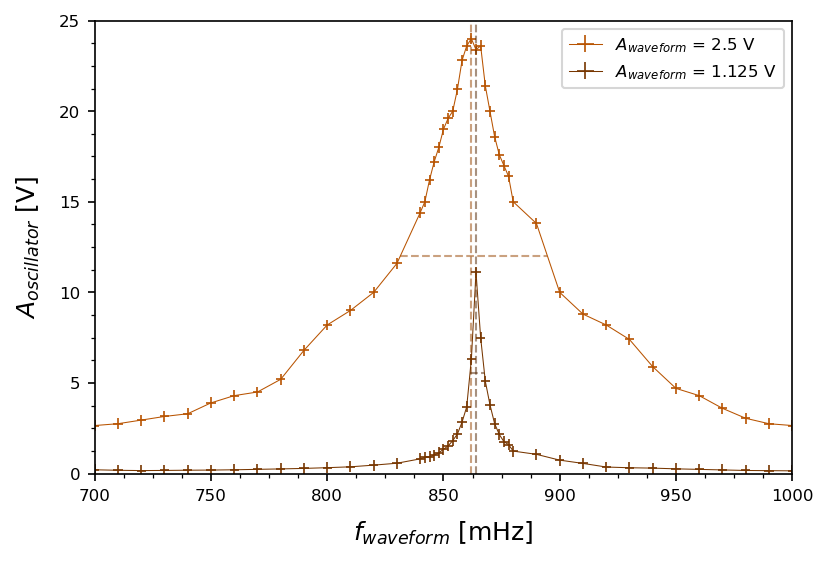

In [12]:
qs = PlotXmanyY_peakFWHM(
    x = [tables['Resonance Vpp=5']['Freqency [mHz]'],
         tables['Resonance Vpp=0.25']['Freqency [mHz]']],
    y  = [tables['Resonance Vpp=5']['Max Amplitude [V]'],
          tables['Resonance Vpp=0.25']['Max Amplitude [V]']],
    yleg = ['$A_{waveform}$ = 2.5 V', '$A_{waveform}$ = 1.125 V'],  
    c =[colors[3],colors_dark[3]],
    xerr = 2,    # error on x axis
    yerr = 0.3,    # error on y axis
    xlim = (700,1000),
    ylim = (0,25),
    xlab = '$f_{waveform}$ [mHz]', # label on x axis 
    ylab = '$A_{oscillator}$ [V]', # label on y axis
    linestyle = '-',   # style of xy curve line
    fileName = path_fig+'resonance_VvsF_vline.png'  # filename to save the figure as
) 

## $v^1$

In [94]:
def PlotXmanyY_LinearFit(
    x: list[np.array], # x axis data points
    y: list[np.array], # y axis data points
    yleg : list[str], # legend lables 
    c : list, # colors
    cfit: list, # colors 
    xmaxFit: float = 0.2, # make linear fit below this value of x
    xerr: float = 0,    # error on x axis
    yerr: float = 0,    # error on y axis
    xlab: str = '', # label on x axis 
    ylab: str = '', # label on y axis
    linestyle = '-',   # style of xy curve line
    xlim: list = None,  # x axis range 
    ylim: list = None,  # y axis range 
    vlines: list = None, 
    hlines: list = None, 
    logScale: bool = False,
    fileName: str = ''  # filename to save the figure as
) : 
    """Plotting function for x and y data arrays."""
    # formatting 
    my.SetStyle()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    if(xlim != None) : plt.xlim(xlim)
    if(ylim != None) : plt.ylim(ylim)
    ax = plt.gca()
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    # ax.grid()
    if(logScale) : ax.set_yscale('log')
    # data
    ax.axvline(0.2, c='gray', linestyle=':')
    for xi,yi,yl,ci,cf in zip(x,y,yleg,c,cfit) : 
        maxY = yi[-1]
        print(maxY)
        plt.axhline(maxY, c=cf, linestyle=':')
        # fit 
        line = xi < xmaxFit
        equn, chi2eqn = LeastSquareFit(plt.gca(), xi[line], yi[line], xmin=xi[0]-1, xmax=0.2, append='_{x<'+str(my_ceil(xmaxFit,1))+'}', pltEq=False, c=cf) 
        # data
        lab = yl + ': ' + str(equn) + ', ' + str(chi2eqn) + '; $y_{max}$ = ' + str(maxY)
        plt.errorbar(xi, yi, yerr=yerr, xerr=xerr, elinewidth=0.8, c=ci, linestyle=linestyle, linewidth=0.5, label=lab)
    if( yleg[0] != None) : plt.legend(fontsize=7)    
    # finish 
    if(fileName != '') : my.Save(fileName)
    plt.show()

19.4
y$_{x<0.2}$ = (82.5$\pm$0.5)x $-$ (0.1$\pm$0.1)  ,  $\chi^2_{x<0.2}$=0.03
17.4
y$_{x<0.2}$ = (70.6$\pm$2.4)x $+$ (0.3$\pm$0.3)  ,  $\chi^2_{x<0.2}$=0.04


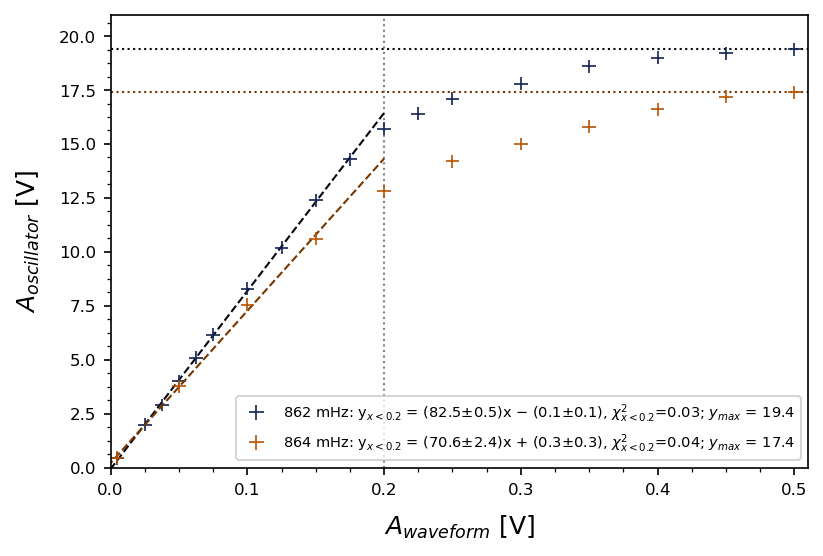

In [227]:
PlotXmanyY_LinearFit(
    x = [tables['V1 Ain-Aout t1']['input Amp. [V]'],
         tables['V1 Ain-Aout t2']['input Amp. [V]']],
    y  = [tables['V1 Ain-Aout t1']['Output Amp. [V]'],
          tables['V1 Ain-Aout t2']['Output Amp. [V]']],
    yleg = ['862 mHz', '864 mHz'],  
    c =[colors[0],colors[3]],
    cfit=[colors_dark[0],colors_dark[3]],
    xerr = 0.005,    # error on x axis
    yerr = 0.3,    # error on y axis
    xlim = (0,.51),
    ylim=(0,21),
    xlab = '$A_{waveform}$ [V]', # label on x axis 
    ylab = '$A_{oscillator}$ [V]', # label on y axis
    linestyle = '',   # style of xy curve line
    fileName = path_fig+'v1_AinAout_linearFit.png'  # filename to save the figure as
) 

In [278]:
def myArc(x,a,b) : 
    return a*np.tanh(b*x)

def Chi2(n, y) : 
    # chi squared test
    chi2, pvalue = stat.chisquare(n, np.sum(n)/np.sum(y) * y)
    return (chi2, pvalue)

def BuildLable(a,b,chi2) -> str :
    return '$y = '+str(my_ceil(a,1))+'\\; \\tanh('+str(b)+'x)$' + ', $\chi^2$ = ' + str(my_ceil(chi2,2))


def FitArc(x,y,a,b,c, lab=False):
    # chi square 
    y_exp = myArc(x,a,b)
    chi2, _ = Chi2(y, y_exp)
    # plot line with nice resolution 
    xs = np.arange(x[0]-1,x[-1]+1,0.01)
    ys = myArc(xs,a,b)
    if(lab):
        plt.plot(xs,ys, c=c, label=BuildLable(a,b,chi2))
    else :
        plt.plot(xs,ys, c=c)
    # finish
    return round(chi2,2)

In [279]:
def PlotXmanyY_TanhFit(
    x: list[np.array], # x axis data points
    y: list[np.array], # y axis data points
    b: list[float],
    yleg : list[str], # legend lables 
    c : list, # colors
    cfit: list, # colors 
    xmaxFit: float = 0.2, # make linear fit below this value of x
    xerr: float = 0,    # error on x axis
    yerr: float = 0,    # error on y axis
    xlab: str = '', # label on x axis 
    ylab: str = '', # label on y axis
    linestyle = '-',   # style of xy curve line
    xlim: list = None,  # x axis range 
    ylim: list = None,  # y axis range 
    logScale: bool = False,
    fileName: str = ''  # filename to save the figure as
) : 
    """Plotting function for x and y data arrays."""
    # formatting 
    my.SetStyle()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    if(xlim != None) : plt.xlim(xlim)
    if(ylim != None) : plt.ylim(ylim)
    ax = plt.gca()
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    # ax.grid()
    if(logScale) : ax.set_yscale('log')
    # data
    for xi,yi,yl,ci,cf,bi in zip(x,y,yleg,c,cfit,b) : 
        a = yi[-1]+.6
        chi2 = FitArc(x=xi,y=yi,a=a,b=bi,c=cf)
        lab = yl  + ': ' + BuildLable(a,bi,chi2)
        plt.errorbar(xi, yi, yerr=yerr, xerr=xerr, elinewidth=0.8, c=ci, linestyle=linestyle, linewidth=0.5, label=lab)
    if( yleg[0] != None) : plt.legend(fontsize=7)    
    # finish 
    if(fileName != '') : my.Save(fileName)
    plt.show()

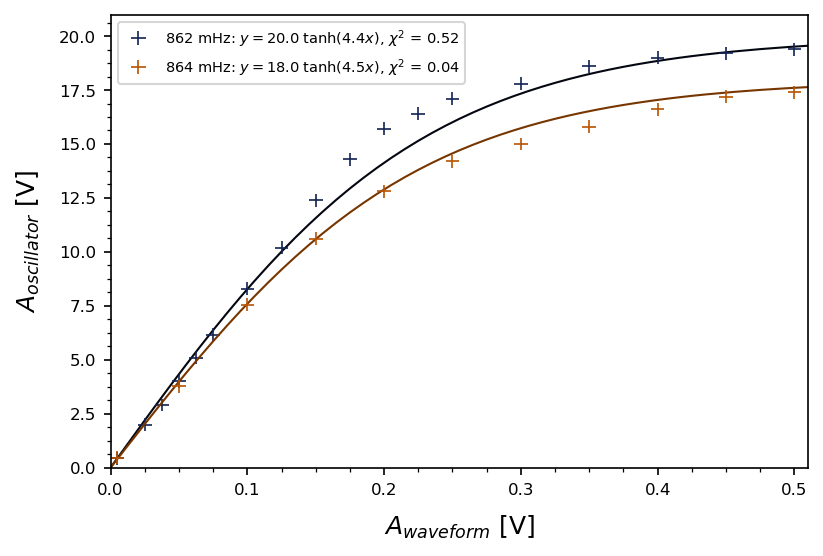

In [280]:
PlotXmanyY_TanhFit(
    x = [tables['V1 Ain-Aout t1']['input Amp. [V]'],
         tables['V1 Ain-Aout t2']['input Amp. [V]']],
    y  = [tables['V1 Ain-Aout t1']['Output Amp. [V]'],
          tables['V1 Ain-Aout t2']['Output Amp. [V]']],
    b = [4.4,4.5],
    yleg = ['862 mHz', '864 mHz'],  
    c =[colors[0],colors[3]],
    cfit=[colors_dark[0],colors_dark[3]],
    xerr = 0.005,    # error on x axis
    yerr = 0.3,    # error on y axis
    xlim = (0,.51),
    ylim=(0,21),
    xlab = '$A_{waveform}$ [V]', # label on x axis 
    ylab = '$A_{oscillator}$ [V]', # label on y axis
    linestyle = '',   # style of xy curve line
    fileName = path_fig+'v1_AinAout_arcFit.png'  # filename to save the figure as
) 

In [271]:
def PlotXmanyY_TanhAndLinearFit(
    x: list[np.array], # x axis data points
    y: list[np.array], # y axis data points
    b: list[float],
    yleg : list[str], # legend lables 
    c : list, # colors
    cfit: list, # colors 
    xmaxFit: float = 0.2, # make linear fit below this value of x
    xerr: float = 0,    # error on x axis
    yerr: float = 0,    # error on y axis
    xlab: str = '', # label on x axis 
    ylab: str = '', # label on y axis
    linestyle = '-',   # style of xy curve line
    xlim: list = None,  # x axis range 
    ylim: list = None,  # y axis range 
    logScale: bool = False,
    fileName: str = ''  # filename to save the figure as
) : 
    """Plotting function for x and y data arrays."""
    # formatting 
    my.SetStyle()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    if(xlim != None) : plt.xlim(xlim)
    if(ylim != None) : plt.ylim(ylim)
    ax = plt.gca()
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    # ax.grid()
    if(logScale) : ax.set_yscale('log')
    # data
    ax.axvline(my_ceil(xmaxFit,2), c='gray', linestyle=':')
    for xi,yi,yl,ci,cf,bi in zip(x,y,yleg,c,cfit,b) : 
        # tanh fit 
        a = yi[-1]+.6
        chi2 = FitArc(x=xi,y=yi,a=a,b=bi,c=cf, lab=True)
        # linear fit 
        line = xi < xmaxFit
        equn, chi2eqn = LeastSquareFit(plt.gca(), xi[line], yi[line], xmin=xi[0]-1, xmax=xi[-1]+1, append='_{x<'+str(my_ceil(xmaxFit,2))+'}', pltEq=False, c=cf, label=True)
        # data
        plt.errorbar(xi, yi, yerr=yerr, xerr=xerr, elinewidth=0.8, c=ci, linestyle=linestyle, linewidth=0.5, label=yl)
    if( yleg[0] != None) : plt.legend(fontsize=7)    
    # finish 
    if(fileName != '') : my.Save(fileName)
    plt.show()

y$_{x<0.18}$ = (83.0$\pm$0.6)x $-$ (0.1$\pm$0.1)  ,  $\chi^2_{x<0.18}$=0.05
y$_{x<0.18}$ = (70.6$\pm$2.4)x $+$ (0.3$\pm$0.3)  ,  $\chi^2_{x<0.18}$=0.04


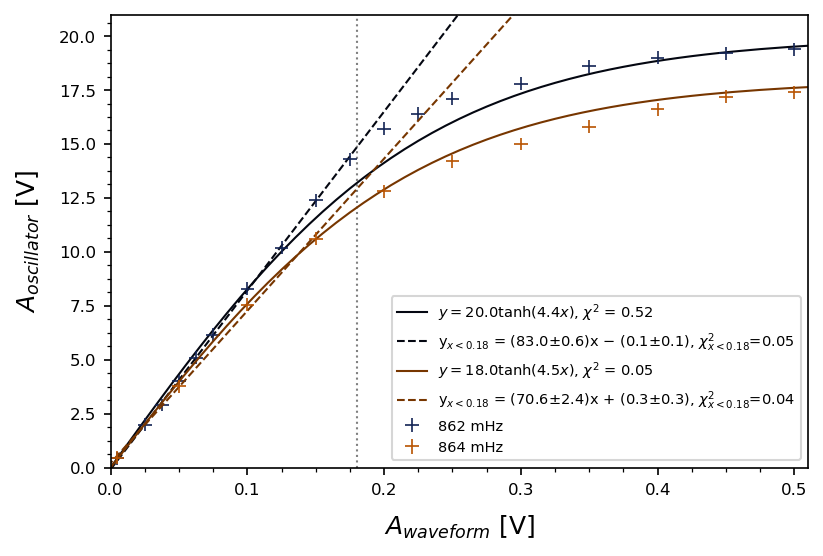

In [272]:
PlotXmanyY_TanhAndLinearFit(
    x = [tables['V1 Ain-Aout t1']['input Amp. [V]'],
         tables['V1 Ain-Aout t2']['input Amp. [V]']],
    y  = [tables['V1 Ain-Aout t1']['Output Amp. [V]'],
          tables['V1 Ain-Aout t2']['Output Amp. [V]']],
    b = [4.4,4.5],
    yleg = ['862 mHz', '864 mHz'],  
    c =[colors[0],colors[3]],
    cfit=[colors_dark[0],colors_dark[3]],
    xmaxFit=0.175,
    xerr = 0.005,    # error on x axis
    yerr = 0.3,    # error on y axis
    xlim = (0,.51),
    ylim=(0,21),
    xlab = '$A_{waveform}$ [V]', # label on x axis 
    ylab = '$A_{oscillator}$ [V]', # label on y axis
    linestyle = '',   # style of xy curve line
    fileName = path_fig+'v1_AinAout_arcLineFit.png'  # filename to save the figure as
) 


## $v^0$

In [101]:
def PlotXmanyY(
    x: list[np.array], # x axis data points
    y: list[np.array], # y axis data points
    v: list[float],
    yleg : list[str], # legend lables 
    c : list, # colors
    c_fit : list, # colors 
    xerr: float = 0,    # error on x axis
    yerr: float = 0,    # error on y axis
    xlab: str = '', # label on x axis 
    ylab: str = '', # label on y axis
    linestyle = '-',   # style of xy curve line
    xlim: list = None,  # x axis range 
    ylim: list = None,  # y axis range 
    logScale: bool = False,
    fileName: str = ''  # filename to save the figure as
) : 
    """Plotting function for x and y data arrays."""
    # formatting 
    my.SetStyle()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    if(xlim != None) : plt.xlim(xlim)
    if(ylim != None) : plt.ylim(ylim)
    ax = plt.gca()
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    # ax.grid()
    if(logScale) : ax.set_yscale('log')

    maximum = max([ yi[-1] for yi in y])
    print('Max: ', maximum)
    ax.axhline(maximum, c='gray', linestyle=':')
    ax.axhline(0, c='gray', linestyle=':')

    # data
    for xi,yi,yl,ci,cf,vi in zip(x,y,yleg,c,c_fit,v) :
        ax.axvline(vi, c=cf, linestyle=':')
        lab = yl+': $x_{min}$ = ' + str(vi)
        plt.errorbar(xi, yi, yerr=yerr, xerr=xerr, elinewidth=0.8, c=ci, linestyle=linestyle, linewidth=0.5, label=lab)
    
    
    if( yleg[0] != None) : plt.legend(loc='lower right')
    # finish 
    if(fileName != '') : my.Save(fileName)
    plt.show()

Max:  21.4


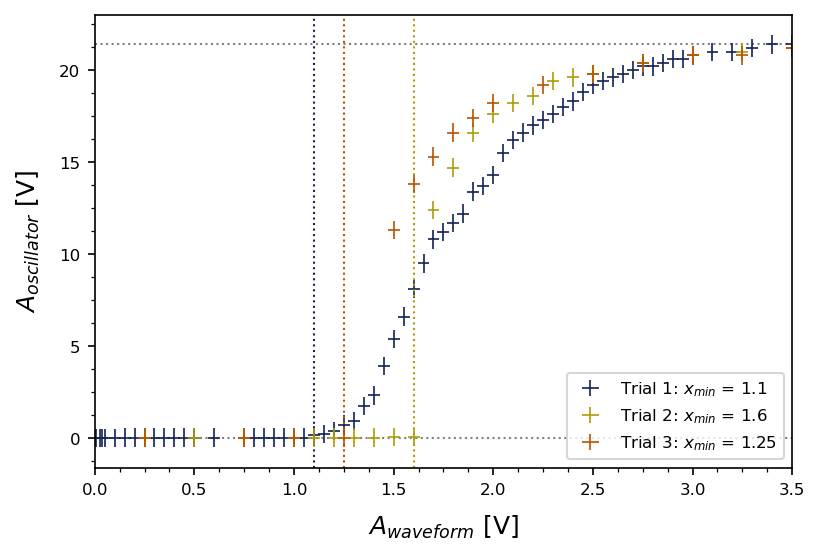

In [102]:
PlotXmanyY(
    x = [
         tables['V0 Ain-Aout t1']['input Amp. [V]'],
         tables['V0 Ain-Aout t2']['input Amp. [V]'],
         tables['V0 Ain-Aout t4']['input Amp. [V]']
         ],
    y  = [
          tables['V0 Ain-Aout t1']['Output Amp. [V]'],
          tables['V0 Ain-Aout t2']['Output Amp. [V]'],
          tables['V0 Ain-Aout t4']['Output Amp. [V]']
          ],
    v = [
        1.1,
        1.6,
        1.25,
        ],
    yleg = ['Trial 1', 'Trial 2', 'Trial 3',],  
    c =[colors[0],colors[2],colors[3]],
    c_fit =[colors[0],colors[2],colors[3]],
    xerr = 0.03,    # error on x axis
    yerr = 0.5,    # error on y axis
    xlim = (0,3.5),
    # ylim=(0,21),
    xlab = '$A_{waveform}$ [V]', # label on x axis 
    ylab = '$A_{oscillator}$ [V]', # label on y axis
    linestyle = '',   # style of xy curve line
    fileName = path_fig+'v1_AinAout_cleaner_fit.png'  # filename to save the figure as
) 